In [1]:
!pip install -q transformers datasets evaluate torch accelerate gradio

In [2]:
from datasets import load_dataset

#load dataset IMDB
dataset = load_dataset("imdb")

small_train =  dataset["train"].shuffle(seed=42).select(range(2000))
small_test = dataset["test"].shuffle(seed=42).select(range(1000))

print(small_train[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}


In [3]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
  return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = small_train.map(tokenize_function, batched=True)
test_dataset = small_test.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["text"]).rename_column("label", "labels")
test_dataset =  test_dataset.remove_columns(["text"]).rename_column("label", "labels")

train_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [5]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = logits.argmax(-1)
  return accuracy.compute(predictions=predictions, references=labels)


In [6]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./sentiment_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,          # Increase to 3-5 if you have time/GPU
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.471101,0.355585,0.851000
2,0.222137,0.322384,0.865000
3,0.157452,0.331620,0.884000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=375, training_loss=0.2877532958984375, metrics={'train_runtime': 398.0773, 'train_samples_per_second': 15.072, 'train_steps_per_second': 0.942, 'total_flos': 794804391936000.0, 'train_loss': 0.2877532958984375, 'epoch': 3.0})

In [8]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.3316202461719513, 'eval_accuracy': 0.884, 'eval_runtime': 16.3502, 'eval_samples_per_second': 61.161, 'eval_steps_per_second': 3.853, 'epoch': 3.0}


In [9]:
!pip install wordcloud

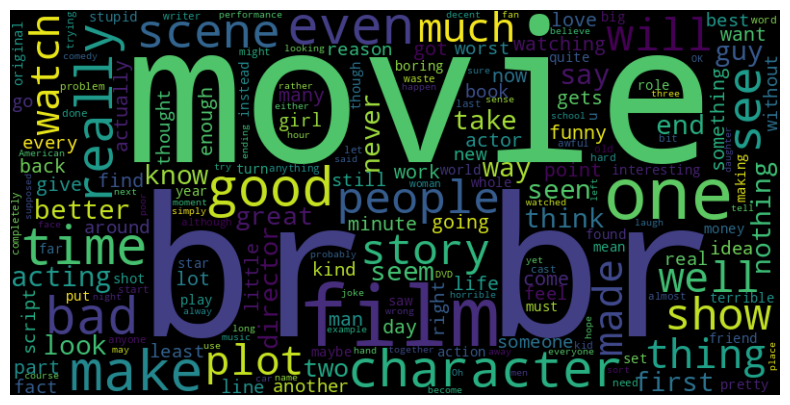

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

negative_texts = " ".join([ex["text"] for ex in small_test if ex["label"] == 0])
wordcloud = WordCloud(width = 800, height = 400).generate(negative_texts)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [11]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
)

Using device: GPU


In [12]:
test_inputs = [
    "Movie was great",
    "This film is terrible and boring",
    "It was okay I guess"
]

for txt in test_inputs:
    try:
        res = sentiment_pipeline(txt)[0]
        print(f"Input: {txt}")
        print(f"Raw output: {res}")
        label = "Positive" if res['label'] == "LABEL_1" else "Negative"
        print(f"→ {label} ({res['score']:.2%})\n")
    except Exception as e:
        print(f"Failed on '{txt}': {str(e)}\n")

Input: Movie was great
Raw output: {'label': 'LABEL_1', 'score': 0.9622179865837097}
→ Positive (96.22%)

Input: This film is terrible and boring
Raw output: {'label': 'LABEL_0', 'score': 0.9675747752189636}
→ Negative (96.76%)

Input: It was okay I guess
Raw output: {'label': 'LABEL_1', 'score': 0.5920686721801758}
→ Positive (59.21%)



In [13]:
import gradio as gr

def predict_sentiment(text):
    if not text or not text.strip():
        return "Please enter a movie review!"

    try:
        result = sentiment_pipeline(text)[0]
        label = "Positive 😊" if result['label'] == "LABEL_1" else "Negative 😞"
        score = result['score']

        if score < 0.60:
            confidence = "low confidence"
        elif score < 0.85:
            confidence = "moderate confidence"
        else:
            confidence = "high confidence"

        return f"**{label}**\nConfidence: {score:.1%} ({confidence})"
    except Exception as e:
        return f"Oops, something went wrong: {str(e)}"

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(
        lines=6,
        placeholder="Write your movie review here...",
        label="Your Review"
    ),
    outputs=gr.Markdown(label="Prediction"),
    title="🎬 Movie Review Sentiment Analyzer",
    description="Fine-tuned DistilBERT model trained on IMDB movie reviews (2000 examples).",
    examples=[
        ["This movie changed my life! Best film ever."],
        ["Waste of time, terrible acting and boring plot."],
        ["It was alright, nothing special."],
        ["The visuals were stunning but the story fell flat."]
    ],
    theme="soft",  # or "default", "huggingface"
    allow_flagging="never"
)

demo.launch(debug=True)

/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2232f78f616bdd4041.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://2232f78f616bdd4041.gradio.live


In [14]:
save_directory = "my_imdb_sentiment_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('my_imdb_sentiment_model/tokenizer_config.json',
 'my_imdb_sentiment_model/tokenizer.json')

In [15]:
%%writefile app.py
import gradio as gr
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model & tokenizer from the local folder (uploaded to this Space)
model_dir = "./my_imdb_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

# Optional: move to GPU if available
device = 0 if torch.cuda.is_available() else -1
model.to(device) if device == 0 else None

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
)

def predict_sentiment(text):
    if not text or not text.strip():
        return "Please enter a movie review!"

    try:
        result = sentiment_pipeline(text)[0]
        label = "Positive 😊" if result['label'] == "LABEL_1" else "Negative 😞"
        score = result['score']

        if score < 0.60:
            conf_text = "low confidence"
        elif score < 0.85:
            conf_text = "moderate confidence"
        else:
            conf_text = "high confidence"

        return f"**{label}**\nConfidence: {score:.1%} ({conf_text})"
    except Exception as e:
        return f"Error during prediction: {str(e)}"

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(
        lines=6,
        placeholder="Write your movie review here...",
        label="Your Movie Review"
    ),
    outputs=gr.Markdown(label="Result"),
    title="🎬 Movie Review Sentiment Analyzer",
    description="Fine-tuned DistilBERT on IMDB reviews. Enter a review to see if it's positive or negative.",
    examples=[
        ["This movie was absolutely fantastic and heartwarming!"],
        ["Worst film I've seen in years. Terrible acting."],
        ["It was okay, nothing special but not bad either."],
        ["The plot twists kept me on the edge of my seat!"]
    ],
    theme="soft",
    allow_flagging="never"
)

if __name__ == "__main__":
    demo.launch()

Writing app.py


In [16]:
%%writefile requirements.txt
gradio
transformers
torch
accelerate

Writing requirements.txt


In [17]:
%%writefile app.py
import gradio as gr
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load from the uploaded model folder in this Space
model_dir = "./my_imdb_sentiment_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

# Use GPU if available in Space
device = 0 if torch.cuda.is_available() else -1
model.to(device) if device == 0 else None

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
)

def predict_sentiment(text):
    if not text or not text.strip():
        return "Please enter a movie review!"

    try:
        result = sentiment_pipeline(text)[0]
        label = "Positive 😊" if result['label'] == "LABEL_1" else "Negative 😞"
        score = result['score']

        if score < 0.60:
            conf_text = "low confidence"
        elif score < 0.85:
            conf_text = "moderate confidence"
        else:
            conf_text = "high confidence"

        return f"**{label}**\nConfidence: {score:.1%} ({conf_text})"
    except Exception as e:
        return f"Error during prediction: {str(e)}"

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(
        lines=6,
        placeholder="Write your movie review here...",
        label="Your Movie Review"
    ),
    outputs=gr.Markdown(label="Result"),
    title="🎬 Movie Review Sentiment Analyzer",
    description="Fine-tuned DistilBERT on IMDB reviews. Enter a review to see if it's positive or negative.",
    examples=[
        ["This movie was absolutely fantastic and heartwarming!"],
        ["Worst film I've seen in years. Terrible acting."],
        ["It was okay, nothing special but not bad either."],
        ["The plot twists kept me on the edge of my seat!"]
    ],
    theme="soft",
    allow_flagging="never"
)

if __name__ == "__main__":
    demo.launch()

Overwriting app.py


In [18]:
!zip -r my_imdb_sentiment_model.zip my_imdb_sentiment_model

  adding: my_imdb_sentiment_model/ (stored 0%)
  adding: my_imdb_sentiment_model/config.json (deflated 49%)
  adding: my_imdb_sentiment_model/model.safetensors (deflated 8%)
  adding: my_imdb_sentiment_model/tokenizer_config.json (deflated 42%)
  adding: my_imdb_sentiment_model/tokenizer.json (deflated 71%)


In [19]:
from google.colab import files
files.download('my_imdb_sentiment_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from huggingface_hub import login, HfApi

# Log in (create token at https://huggingface.co/settings/tokens with write access)
login()   # Paste your token when prompted

In [22]:
# Push model & tokenizer (replace with your desired repo name)
model_repo_id = "qaimraza/imdb-sentiment-distilbert"   # Change if you want

model.push_to_hub(model_repo_id)
tokenizer.push_to_hub(model_repo_id)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...147n8tb/model.safetensors:   9%|9         | 25.0MB /  268MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/qaimraza/imdb-sentiment-distilbert/commit/6715c48f0ac1d20e4135583f9876e1fff9d733ee', commit_message='Upload tokenizer', commit_description='', oid='6715c48f0ac1d20e4135583f9876e1fff9d733ee', pr_url=None, repo_url=RepoUrl('https://huggingface.co/qaimraza/imdb-sentiment-distilbert', endpoint='https://huggingface.co', repo_type='model', repo_id='qaimraza/imdb-sentiment-distilbert'), pr_revision=None, pr_num=None)

In [23]:
%%writefile README.md
# Movie Review Sentiment Analyzer

A fine-tuned DistilBERT model that classifies movie reviews as **Positive** or **Negative**.

## Live Demo
https://huggingface.co/spaces/qaimraza/movie-sentiment-analyzer

## Model on Hugging Face Hub
https://huggingface.co/qaimraza/imdb-sentiment-distilbert

## Technologies
- Python
- Hugging Face Transformers (DistilBERT)
- Gradio (UI)
- PyTorch
- Google Colab (training)
- Hugging Face Spaces (deployment)

## How to run locally

1. Clone the repo
```bash
git clone https://github.com/qaimraza/movie-sentiment-analyzer.git
cd movie-sentiment-analyzer

Writing README.md
